In [ ]:
# !unzip IIIT5K-Word_V3.0_revised.zip

In [1]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import Dataset,DataLoader,SequentialSampler,SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

import cv2,os, warnings,joblib
from skimage import io,transform
import pandas as pd

warnings.filterwarnings('ignore')

### DataLoading

In [2]:
class IIITDataset(Dataset):
    def __init__(self, csv_filename, image_dir, transform=None):
        self.dataset = pd.read_csv(csv_filename)
        self.root_dir = image_dir
        self.transform = transform
    
    def __getitem__(self,index):
        if(torch.is_tensor(index)):
            index = index.tolist()
        label = self.dataset.iloc[index,1] # here label column = 1
        
        image_name = self.dataset.iloc[index,0] #here image path column=0
        path = os.path.join(self.root_dir,image_name)
        image = Image.open(path)
        if self.transform:
            image = self.transform(image)
        
        return image, label
        
    def __len__(self):
        return len(self.dataset)
    
# This LabelTransformer class: referred from online source https://github.com/qjy981010/CRNN.pytorch.IIIT-5K
class LabelTransformer(object):
    """
    encoder and decoder
    Args:
        letters (str): Letters contained in the data
    """

    def __init__(self, letters):
        self.encode_map = {letter: idx+1 for idx, letter in enumerate(letters)}
        self.decode_map = ' ' + letters

    def encode(self, text):
        if isinstance(text, str):
            length = [len(text)]
            result = [self.encode_map[letter] for letter in text]
        else:
            length = []
            result = []
            for word in text:
                length.append(len(word))
                result.extend([self.encode_map[letter] for letter in word])
        return torch.IntTensor(result), torch.IntTensor(length)

    def decode(self, text_code):
        result = []
        for code in text_code:
            word = []
            for i in range(len(code)):
                if code[i] != 0 and (i == 0 or code[i] != code[i-1]):
                    word.append(self.decode_map[code[i]])
            result.append(''.join(word))
        return result

In [3]:
train_path = r"E:\Sem3\AML\Assignments & Quiz\Assignment_5\Dataset\IIIT5K-Word_V3.0\IIIT5K"
test_path = r"E:\Sem3\AML\Assignments & Quiz\Assignment_5\Dataset\IIIT5K-Word_V3.0\IIIT5K"

# train_path = "IIIT5K"
# test_path = "IIIT5K"

device='cuda'
# device = 'cpu'
n_workers = 0
batch_size = 10

transform = transforms.Compose([
                                transforms.Resize((32,100),Image.BICUBIC),
                                transforms.Grayscale(),
                                transforms.ToTensor()
                               ])

train_data = IIITDataset(csv_filename="train.csv", image_dir=train_path, transform=transform)
test_data = IIITDataset(csv_filename="test.csv", image_dir=test_path, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=n_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=n_workers)

### Architecture

In [7]:
class Architecture(nn.Module):
    def __init__(self, in_channels, out_size):
        super(Architecture,self).__init__()
        
        hidden_size = 256
        self.conv_1 = nn.Conv2d(in_channels, 64, 3 ,padding=1, stride=1)
        self.pool_1 = nn.MaxPool2d((2,2),stride=(2,2))
        
        self.conv_2 = nn.Conv2d(64, 128, 3 ,padding=1, stride=1)
        self.pool_2 = nn.MaxPool2d((2,2),stride=(2,2))
        
        self.conv_3 = nn.Conv2d(128, 256, 3 ,padding=1, stride=1)
        self.conv_4 = nn.Conv2d(256, 256, 3 ,padding=1, stride=1)
        self.pool_3 = nn.MaxPool2d((2,1),stride=(2,1))
        
        self.conv_5 = nn.Conv2d(256, 512, 3 ,padding=1, stride=1)
        self.b_1 = nn.BatchNorm2d(512)
        
        self.conv_6 = nn.Conv2d(512, 512, 3 ,padding=1, stride=1)
        self.b_2 = nn.BatchNorm2d(512)
        self.pool_4 = nn.MaxPool2d((2,1),stride=(2,1))
        
        self.conv_7 = nn.Conv2d(512, 512, 2 ,padding=0, stride=1)
        
        self.L_1 = nn.LSTM(input_size = 512, hidden_size = hidden_size, bidirectional=True) 
        self.L_2 = nn.LSTM(input_size = hidden_size*2, hidden_size = 256, bidirectional=True)# input = inputsize*direction
        
        self.fc1 = nn.Linear(hidden_size*2,out_size)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
#         print(x.shape)
        x = self.pool_1(self.relu(self.conv_1(x)))
#         print('pool_1:',x.shape)
        x = self.pool_2(self.relu(self.conv_2(x)))
#         print('pool_2:',x.shape)
        x = self.pool_3(self.relu(self.conv_4(self.relu(self.conv_3(x)))))
#         print('pool_3:',x.shape)
        x = self.b_1(self.relu(self.conv_5(x)))
#         print('b_1:',x.shape)
        x = self.b_2(self.relu(self.conv_6(x)))
#         print('b_2:',x.shape)
        x = self.pool_4(x)
#         print('pool_4:',x.shape)
        
        x = self.relu(self.conv_7(x))
#         print('conv_7:',x.shape)
    
        x = x.squeeze(2)
#         print('sq:',x.shape)
        
        x = x.permute(2, 0, 1) # seqlength, batch, inputdim
#         print('permute:',x.shape)
        
        results = self.L_1(x)
        out, hidden = results[0], results[1]
#         print('L_1:',out.shape,hidden[0].shape, hidden[1].shape)
        
        results = self.L_2(out)
        out, hidden = results[0], results[1]
#         print('L_2:',out.shape,hidden[0].shape, hidden[1].shape)
        
        x = out
        l, b, h = x.size()
#         print('width,batch,inputDim:',l,b,h)
        
        x = x.view(l*b,h) # length*batch, hidden_size*2
#         print('view:',x.shape)
        
        x = self.fc1(x)
#         print('fc:',x.shape)
        
        x = x.view(l, b, -1)   # seqlength>=24, batch, output_size
#         print('view:',x.shape)
        return x

letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
model = Architecture(1,len(letters) + 1)
model.to(device)

criterion = nn.CTCLoss()
criterion.to(device)
optimizer = optim.Adadelta(model.parameters())

labelTransformer = LabelTransformer(letters)

In [11]:
train_loss_plt, test_loss_plt = [], []
train_accuracy_plt, test_accuracy_plt = [], []

In [24]:
n_epochs = 25
for epoch in range(n_epochs):
    train_loss, test_loss = 0, 0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()

        images = images.to(device)
        label, label_length = labelTransformer.encode(labels)
        
        label.to(device)
        label_length.to(device)
        
        output = model(images)
        output_length = torch.tensor([output.size(0)]*output.size(1)).to(device)
        
#         print(label, label_length, output_length)
        loss = criterion(output, label, output_length, label_length)
        
        result = output.max(2)[1].transpose(0, 1)  # batch × length
        result = labelTransformer.decode(result.data)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_loss_plt.append(train_loss)
    
    model.eval()
    correct=0
    total=0
    for images,labels in test_loader:

        images = images.to(device)
        label, label_length = labelTransformer.encode(labels)
        label.to(device)
        label_length.to(device)
        
        output = model(images)
        output_length = torch.tensor([output.size(0)]*output.size(1)).to(device)
        
        loss = criterion(output, label, output_length, label_length)
        
        result = output.max(2)[1].transpose(0, 1)  # batch × length
        result = labelTransformer.decode(result.data)
        
        test_loss += loss.item() * images.size(0)
        correct += sum([out == real for out,real in zip(result, labels)])
        total += len(labels)
        test_acc = correct / total * 100
    test_accuracy_plt.append(test_acc)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_loss_plt.append(test_loss)
    print('Epoch:', (epoch + 1), '\tTrain Loss:', train_loss, '\tTest Loss:', test_loss)

Epoch: 1 	Train Loss: 2.8025910836458205 	Test Loss: 3.219400096734365
Epoch: 2 	Train Loss: 2.751495018005371 	Test Loss: 3.2761538791656495
Epoch: 3 	Train Loss: 2.7208080321550367 	Test Loss: 3.1871354031562804
Epoch: 4 	Train Loss: 2.6774513775110247 	Test Loss: 3.309882706006368
Epoch: 5 	Train Loss: 2.6515710949897766 	Test Loss: 3.1489305102825167
Epoch: 6 	Train Loss: 2.6088368982076644 	Test Loss: 3.698607292175293
Epoch: 7 	Train Loss: 2.581653482913971 	Test Loss: 3.1162622980276744
Epoch: 8 	Train Loss: 2.573785665631294 	Test Loss: 3.132155621846517
Epoch: 9 	Train Loss: 2.5370084619522095 	Test Loss: 3.0780759012699126
Epoch: 10 	Train Loss: 2.4849024605751038 	Test Loss: 3.5009834575653076
Epoch: 11 	Train Loss: 2.4561623972654343 	Test Loss: 3.11297293027242
Epoch: 12 	Train Loss: 2.428656066060066 	Test Loss: 3.046491667032242
Epoch: 13 	Train Loss: 2.3853194707632066 	Test Loss: 2.9822596009572346
Epoch: 14 	Train Loss: 2.402676675915718 	Test Loss: 2.958336483637492


### Plots

In [17]:
def plot(values,title,xaxis='epochs',yaxis='Loss',color='b'):
    plt.title(title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.plot(np.arange(len(values)),values,color=color)
    plt.show()

### For First 25 epochs

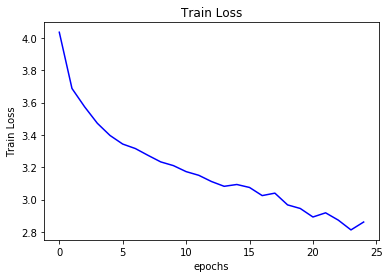

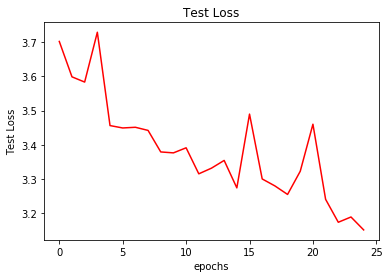

In [23]:
plot(train_loss_plt,'Train Loss','epochs','Train Loss','b')
plot(test_loss_plt,'Test Loss','epochs','Test Loss','r')

### For first 50 epochs

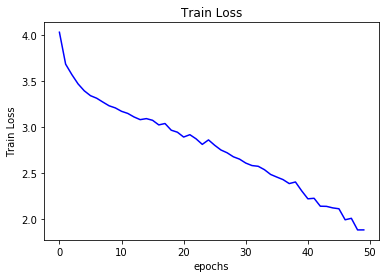

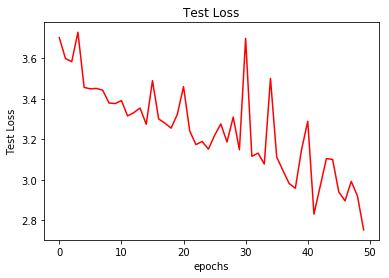

In [25]:
plot(train_loss_plt,'Train Loss','epochs','Train Loss','b')
plot(test_loss_plt,'Test Loss','epochs','Test Loss','r')

### Testing

PAIAITE


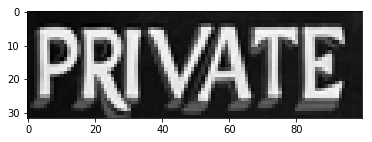

WREASRST


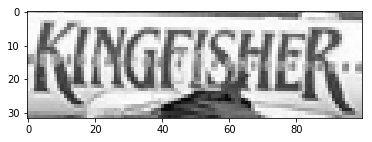

DODINS


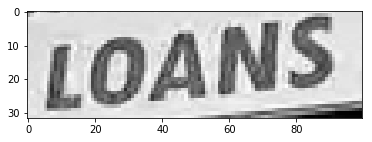

FR


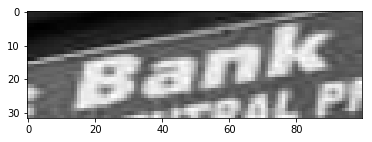

CDER


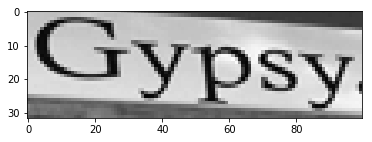

In [30]:
model.eval()
correct=0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    label, label_length = labelTransformer.encode(labels)
    label.to(device)
    label_length.to(device)
    
    output = model(images)
    output_length = torch.tensor([output.size(0)]*output.size(1)).to(device)
    
    loss = criterion(output, label, output_length, label_length)
    
    result = output.max(2)[1].transpose(0, 1)  # batch × length
    result = labelTransformer.decode(result.data)
    print(result[0])
    plt.imshow(images.cpu()[0][0],cmap='gray')
    plt.show()
    if(i==4):
        break